In [31]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [32]:
import os
import cv2

# Base path projet (à adapter)
base_path = '/content/drive/MyDrive/projet_yolo_medical'

# Dossiers images
images_train_dir = os.path.join(base_path, 'data/images/train')
images_val_dir = os.path.join(base_path, 'data/images/test')  # ici test = val

# Dossiers des masques par classe ET par split
masks_dirs_train = {
    0: os.path.join(base_path, 'data/mask/train/microaneurysms'),
    1: os.path.join(base_path, 'data/mask/train/haemorrhages'),
    2: os.path.join(base_path, 'data/mask/train/hard_exudates'),
    3: os.path.join(base_path, 'data/mask/train/soft_exudates'),
    4: os.path.join(base_path, 'data/mask/train/optic_disc'),
}

masks_dirs_val = {
    0: os.path.join(base_path, 'data/mask/test/microaneurysms'),
    1: os.path.join(base_path, 'data/mask/test/haemorrhages'),
    2: os.path.join(base_path, 'data/mask/test/hard_exudates'),
    3: os.path.join(base_path, 'data/mask/test/soft_exudates'),
    4: os.path.join(base_path, 'data/mask/test/optic_disc'),
}

def mask_to_bboxes_yolo(mask_path, class_id, img_width, img_height):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return []
    _, thresh = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bboxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        x_center = (x + w / 2) / img_width
        y_center = (y + h / 2) / img_height
        w_norm = w / img_width
        h_norm = h / img_height
        bboxes.append(f"{class_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}")
    return bboxes

def process_split(images_dir, masks_dirs):
    # Labels dans dossier parallèle à images: remplace 'images' par 'labels'
    labels_dir = images_dir.replace('images', 'labels')
    os.makedirs(labels_dir, exist_ok=True)

    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif'))]

    for img_file in image_files:
        img_path = os.path.join(images_dir, img_file)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Image non lue: {img_path}")
            continue
        h, w = img.shape[:2]

        all_bboxes = []
        base_name = os.path.splitext(img_file)[0]

        for class_id, mask_dir in masks_dirs.items():
            mask_path = os.path.join(mask_dir, base_name + '.tif')  # adapte l'extension si besoin
            bboxes = mask_to_bboxes_yolo(mask_path, class_id, w, h)
            all_bboxes.extend(bboxes)

        label_path = os.path.join(labels_dir, base_name + '.txt')
        with open(label_path, 'w') as f:
            for bbox_line in all_bboxes:
                f.write(bbox_line + '\n')
        print(f"Annotations écrites : {label_path}")

print("Traitement du train...")
process_split(images_train_dir, masks_dirs_train)

print("Traitement du val/test...")
process_split(images_val_dir, masks_dirs_val)

print("Terminé !")


Traitement du train...
Annotations écrites : /content/drive/MyDrive/projet_yolo_medical/data/labels/train/03.txt
Annotations écrites : /content/drive/MyDrive/projet_yolo_medical/data/labels/train/01.txt
Annotations écrites : /content/drive/MyDrive/projet_yolo_medical/data/labels/train/08.txt
Annotations écrites : /content/drive/MyDrive/projet_yolo_medical/data/labels/train/09.txt
Annotations écrites : /content/drive/MyDrive/projet_yolo_medical/data/labels/train/07.txt
Annotations écrites : /content/drive/MyDrive/projet_yolo_medical/data/labels/train/12.txt
Annotations écrites : /content/drive/MyDrive/projet_yolo_medical/data/labels/train/05.txt
Annotations écrites : /content/drive/MyDrive/projet_yolo_medical/data/labels/train/06.txt
Annotations écrites : /content/drive/MyDrive/projet_yolo_medical/data/labels/train/02.txt
Annotations écrites : /content/drive/MyDrive/projet_yolo_medical/data/labels/train/13.txt
Annotations écrites : /content/drive/MyDrive/projet_yolo_medical/data/labels/

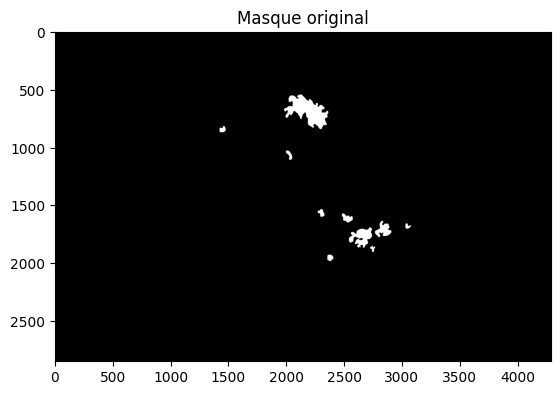

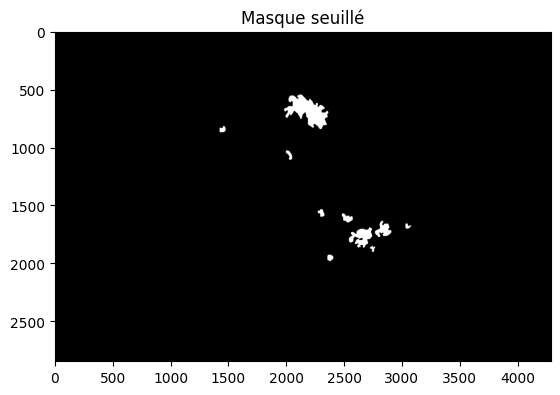

Nombre de contours détectés : 10


In [33]:
import cv2
import matplotlib.pyplot as plt

mask_path = '/content/drive/MyDrive/projet_yolo_medical/data/mask/test/haemorrhages/55.tif'
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(mask, cmap='gray')
plt.title("Masque original")
plt.show()

_, thresh = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray')
plt.title("Masque seuillé")
plt.show()

contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Nombre de contours détectés : {len(contours)}")


In [34]:
# Exemple d’utilisation
image_path = '/content/drive/MyDrive/projet_yolo_medical/data/images/test/55.jpg'
label_path = '/content/drive/MyDrive/projet_yolo_medical/data/labels/test/55.txt'
class_names = ['microaneurysms', 'haemorrhages', 'hard_exudates', 'soft_exudates', 'optic_disc']

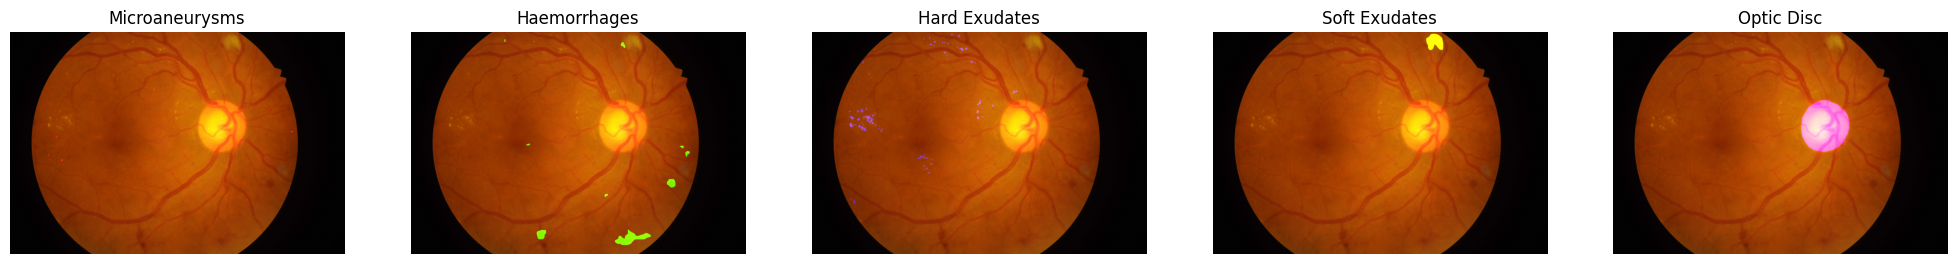

In [35]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def overlay_mask(image, mask, color, alpha=0.8):
    colored_mask = np.zeros_like(image)
    colored_mask[mask > 0] = color
    return cv2.addWeighted(image, 1.0, colored_mask, alpha, 0)

def show_classes_subplots(image_path, masks_dirs, class_names, class_colors):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Trouver les classes présentes (masques non vides)
    present_classes = []
    masks_present = []

    for class_id in class_names.keys():
        mask_path = masks_dirs[class_id]
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if mask is None:
            print(f"Masque manquant pour {class_names[class_id]}")
            continue

        if np.sum(mask) == 0:
            # Masque vide, on ignore
            continue

        present_classes.append(class_id)
        masks_present.append(mask)

    n = len(present_classes)
    if n == 0:
        print("Aucun masque détecté sur cette image.")
        return

    fig, axs = plt.subplots(1, n, figsize=(5 * n, 5))
    if n == 1:
        axs = [axs]  # pour que axs soit itérable même si 1 subplot

    for i, class_id in enumerate(present_classes):
        ax = axs[i]
        mask = masks_present[i]

        overlay = overlay_mask(img_rgb, mask, class_colors[class_id])
        ax.imshow(overlay)
        ax.set_title(class_names[class_id])
        ax.axis('off')

    plt.show()

# Exemple d'utilisation, même que toi
base_path = '/content/drive/MyDrive/projet_yolo_medical/data/mask/train'
image_path = '/content/drive/MyDrive/projet_yolo_medical/data/images/train/47.jpg'

masks_dirs = {
    0: f'{base_path}/microaneurysms/47.tif',
    1: f'{base_path}/haemorrhages/47.tif',
    2: f'{base_path}/hard_exudates/47.tif',
    3: f'{base_path}/soft_exudates/47.tif',
    4: f'{base_path}/optic_disc/47.tif',
}

class_names = {
    0: 'Microaneurysms',
    1: 'Haemorrhages',
    2: 'Hard Exudates',
    3: 'Soft Exudates',
    4: 'Optic Disc',
}

class_colors = {
    0: (255, 0, 0),      # rouge
    1: (0, 255, 0),      # vert
    2: (0, 0, 255),      # bleu
    3: (255, 255, 0),    # jaune
    4: (255, 0, 255),    # magenta
}

show_classes_subplots(image_path, masks_dirs, class_names, class_colors)
